<a href="https://colab.research.google.com/github/kolmar7/rdf/blob/main/%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B8%D0%B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3483457248.py:55: RuntimeWarning: invalid value encountered in divide
  g += hist / (rho * Ai)
/tmp/ipython-input-3483457248.py:55: RuntimeWarning: divide by zero encountered in divide
  g += hist / (rho * Ai)


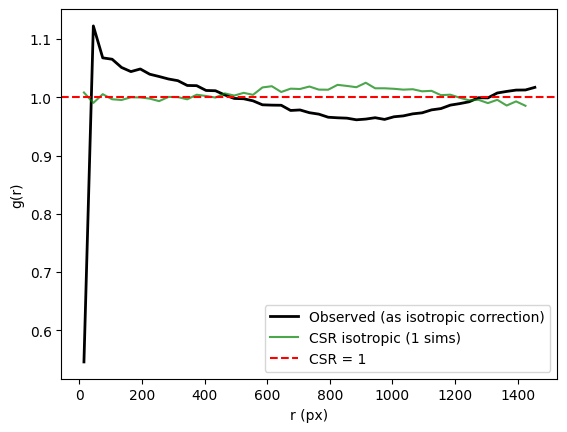

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

#парсинг XML
def parsing_xml(xml_path: str, marker_type: int = 1):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    xc, yc = [], []
    for mtype in root.findall(".//Marker_Type"):
        t = mtype.findtext("Type")
        if not t or int(t.strip()) != marker_type:
            continue
        for m in mtype.findall(".//Marker"):
            x = m.findtext("MarkerX")
            y = m.findtext("MarkerY")
            if x and y:
                xc.append(int(x)); yc.append(int(y))
    return np.asarray(xc, dtype=np.int64), np.asarray(yc, dtype=np.int64)

#доля окружности внутри кадра
def accessible_fraction_per_point(xi, yi, r, width, height, n_theta=720):
    thetas = np.linspace(0, 2*np.pi, n_theta, endpoint=False)
    x_ring = xi + r * np.cos(thetas)
    y_ring = yi + r * np.sin(thetas)
    inside = (x_ring >= 0) & (x_ring < width) & (y_ring >= 0) & (y_ring < height)
    return np.mean(inside)

# pcf as isotropic correction in R
def rdf_isotropic(x, y, width, height, dr=30.0, r_max=None, n_theta=720):
    x = np.asarray(x, float); y = np.asarray(y, float)
    n = len(x); assert n >= 2
    if r_max is None: r_max = min(width, height)

    area = width * height
    rho = n / area

    r_edges = np.arange(0, r_max+dr, dr, dtype=float)
    r = 0.5 * (r_edges[:-1] + r_edges[1:])
    g = np.zeros(len(r), dtype=float)

    for i in range(n):
        dx = x - x[i]
        dy = y - y[i]
        d = np.sqrt(dx*dx + dy*dy)
        d = d[d > 0]

        hist, _ = np.histogram(d, bins=r_edges)

        #доступная площадь кольца для n точки
        Fi = np.array([accessible_fraction_per_point(x[i], y[i], rk, width, height, n_theta)
                       for rk in r])
        Ai = 2*np.pi*r*dr * Fi

        g += hist / (rho * Ai)

    g /= n
    return r, g

def rdf_isotropic_csr(width, height, n_points, dr=30.0, r_max=None, n_theta=720, n_sim=None, seed=None):
    rng = np.random.default_rng(seed)
    g_accum = None

    for _ in range(n_sim):
        # случайные точки
        xr = rng.uniform(0, width, size=n_points)
        yr = rng.uniform(0, height, size=n_points)

        r, g_tmp = rdf_isotropic(xr, yr, width, height, dr=dr, r_max=r_max, n_theta=n_theta)

        if g_accum is None:
            g_accum = g_tmp
        else:
            g_accum += g_tmp

    g_mean = g_accum / n_sim
    return r, g_mean



#запуск
xml_file = "/content/HaCaT@pla-gel-CPNW@PMMA(11x11,x20)_2022-05-30_CellCounter_tile_x001_y002.xml"
x, y = parsing_xml(xml_file, marker_type=1)

W = int(x.max()) + 1
H = int(y.max()) + 1

rstep = 30
rmax = 1.0 * min(W, H)

# g(r)
r, g_iso = rdf_isotropic(x, y, W, H, dr=rstep, r_max=rmax)

r_csr, g_csr = rdf_isotropic_csr(W, H, len(x), dr=rstep, r_max=rmax, n_theta=720, n_sim=1, seed=123)

plt.plot(r, g_iso, 'k-', lw=2, label="Observed (as isotropic correction)")
plt.plot(r_csr, g_csr, color="green", lw=1.5, alpha=0.7, label="CSR isotropic (1 sims)")
plt.axhline(1.0, color="red", linestyle="--", label="CSR = 1")
plt.xlabel("r (px)")
plt.ylabel("g(r)")
plt.legend()
plt.show()


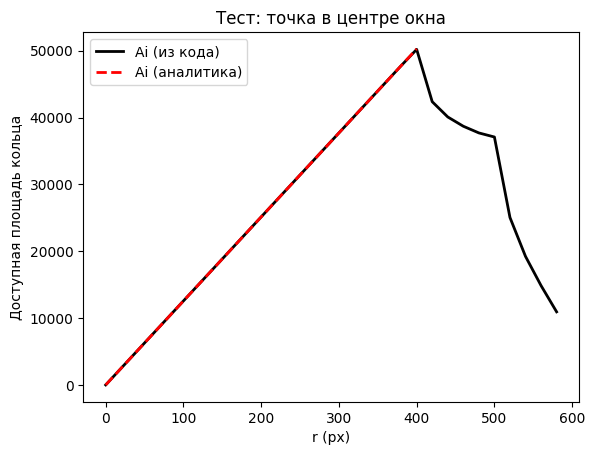

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def accessible_fraction_per_point(xi, yi, r, width, height, n_theta=720):
    thetas = np.linspace(0, 2*np.pi, n_theta, endpoint=False)
    x_ring = xi + r * np.cos(thetas)
    y_ring = yi + r * np.sin(thetas)
    inside = (x_ring >= 0) & (x_ring < width) & (y_ring >= 0) & (y_ring < height)
    return np.mean(inside)

W, H = 1000, 800
xc, yc = W/2, H/2

dr = 20
r = np.arange(0, 600, dr)
Fi = np.array([accessible_fraction_per_point(xc, yc, rk, W, H) for rk in r])
Ai_code = 2*np.pi*r*dr * Fi

# аналитическая формула для центра
Ai_theory = 2*np.pi*r*dr
Ai_theory[r > min(W,H)/2] = np.nan

# график
plt.plot(r, Ai_code, 'k-', lw=2, label="Ai (из кода)")
plt.plot(r, Ai_theory, 'r--', lw=2, label="Ai (аналитика)")
plt.xlabel("r (px)")
plt.ylabel("Доступная площадь кольца")
plt.title("Тест: точка в центре окна")
plt.legend()
plt.show()

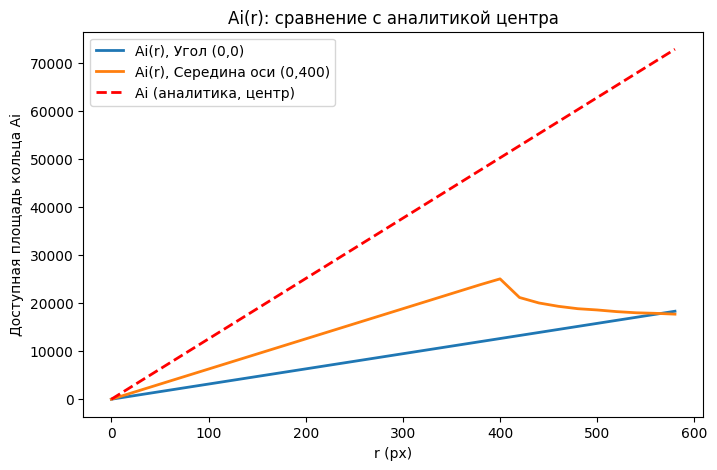

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def accessible_fraction_per_point(xi, yi, r, width, height, n_theta=720):
    thetas = np.linspace(0, 2*np.pi, n_theta, endpoint=False)
    x_ring = xi + r * np.cos(thetas)
    y_ring = yi + r * np.sin(thetas)
    inside = (x_ring >= 0) & (x_ring < width) & (y_ring >= 0) & (y_ring < height)
    return np.mean(inside)

# окно
W, H = 1000, 800
dr = 20
r = np.arange(0, 600, dr)

# точки
points = {
    "Угол (0,0)": (0, 0),
    "Середина оси (0,400)": (0, 400)
}

results = {}
for label, (xc, yc) in points.items():
    Fi = np.array([accessible_fraction_per_point(xc, yc, rk, W, H) for rk in r])
    Ai = 2*np.pi*r*dr * Fi
    results[label] = (Fi, Ai)

#График Ai(r)
plt.figure(figsize=(8,5))
for label, (Fi, Ai) in results.items():
    plt.plot(r, Ai, lw=2, label=f"Ai(r), {label}")

# аналитическая линия для центра
Ai_center_theory = 2*np.pi*r*dr
plt.plot(r, Ai_center_theory, 'r--', lw=2, label="Ai (аналитика, центр)")

plt.xlabel("r (px)")
plt.ylabel("Доступная площадь кольца Ai")
plt.title("Ai(r): сравнение с аналитикой центра")
plt.legend()
plt.show()


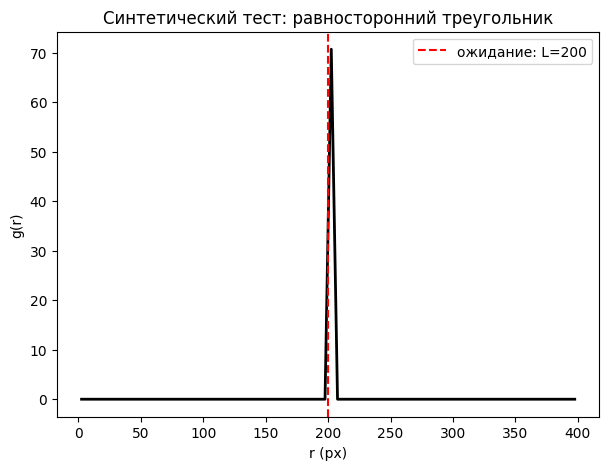

In [ ]:
#доля окружности внутри кадра
def accessible_fraction_per_point(xi, yi, r, width, height, n_theta=720):
    thetas = np.linspace(0, 2*np.pi, n_theta, endpoint=False)
    x_ring = xi + r * np.cos(thetas)
    y_ring = yi + r * np.sin(thetas)
    inside = (x_ring >= 0) & (x_ring < width) & (y_ring >= 0) & (y_ring < height)
    return np.mean(inside)

# pcf as isotropic correction in R
def rdf_isotropic(x, y, width, height, dr=30.0, r_max=None, n_theta=720):
    x = np.asarray(x, float); y = np.asarray(y, float)
    n = len(x); assert n >= 2
    if r_max is None: r_max = 0.5 * min(width, height)

    area = width * height
    rho = n / area

    r_edges = np.arange(0, r_max+dr, dr, dtype=float)
    r = 0.5 * (r_edges[:-1] + r_edges[1:])
    g = np.zeros(len(r), dtype=float)

    for i in range(n):
        dx = x - x[i]
        dy = y - y[i]
        d = np.sqrt(dx*dx + dy*dy)
        d = d[d > 0]

        hist, _ = np.histogram(d, bins=r_edges)
        Fi = np.array([accessible_fraction_per_point(x[i], y[i], rk, width, height, n_theta)
                       for rk in r])
        Ai = 2*np.pi*r*dr * Fi

        g += hist / (rho * Ai)

    g /= n
    return r, g
# равносторонний треугольник
L = 200
x = np.array([0, L, L/2])
y = np.array([0, 0, L*np.sqrt(3)/2])

W, H = 500, 500
r, g = rdf_isotropic(x, y, W, H, dr=5, r_max=400)

# график
plt.figure(figsize=(7,5))
plt.plot(r, g, 'k-', lw=2)
plt.axvline(L, color="red", linestyle="--", label=f"ожидание: L={L}")
plt.xlabel("r (px)")
plt.ylabel("g(r)")
plt.title("Синтетический тест: равносторонний треугольник")
plt.legend()
plt.show()





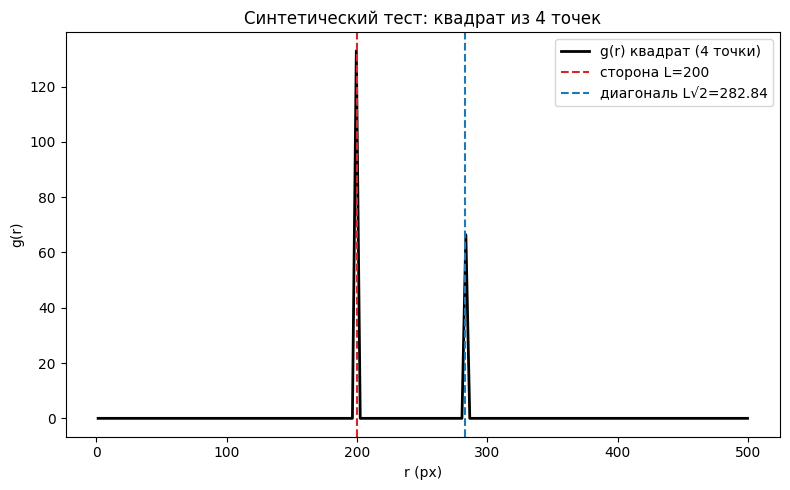

In [ ]:
def accessible_fraction_per_point(xi, yi, r, width, height, n_theta=720):
    thetas = np.linspace(0, 2*np.pi, n_theta, endpoint=False)
    x_ring = xi + r * np.cos(thetas)
    y_ring = yi + r * np.sin(thetas)
    inside = (x_ring >= 0) & (x_ring < width) & (y_ring >= 0) & (y_ring < height)
    return np.mean(inside)

# pcf as isotropic correction in R
def rdf_isotropic(x, y, width, height, dr=None, r_max=None, n_theta=720):
    x = np.asarray(x, float); y = np.asarray(y, float)
    n = len(x); assert n >= 2
    if r_max is None: r_max = 0.5 * min(width, height)

    area = width * height
    rho = n / area

    r_edges = np.arange(0, r_max+dr, dr, dtype=float)
    r = 0.5 * (r_edges[:-1] + r_edges[1:])
    g = np.zeros(len(r), dtype=float)

    for i in range(n):
        dx = x - x[i]
        dy = y - y[i]
        d = np.sqrt(dx*dx + dy*dy)
        d = d[d > 0]

        hist, _ = np.histogram(d, bins=r_edges)
        Fi = np.array([accessible_fraction_per_point(x[i], y[i], rk, width, height, n_theta)
                       for rk in r])
        Ai = 2*np.pi*r*dr * Fi

        g += hist / (rho * Ai)

    g /= n
    return r, g
L = 200.0
# квадрат
margin = 200.0
x = np.array([0, L, L, 0]) + margin
y = np.array([0, 0, L, L]) + margin

# окно
W, H = 1000, 1000

r_max = 500
dr=3.0

r, g = rdf_isotropic(x, y, W, H, dr, r_max=r_max)

L1 = L
L2 = L*np.sqrt(2)

# график
plt.figure(figsize=(8,5))
plt.plot(r, g, 'k-', lw=2, label="g(r) квадрат (4 точки)")
plt.axvline(L1, color="tab:red", linestyle="--", label=f"сторона L={L1:g}")
plt.axvline(L2, color="tab:blue", linestyle="--", label=f"диагональ L√2={L2:.2f}")
plt.xlabel("r (px)")
plt.ylabel("g(r)")
plt.title("Синтетический тест: квадрат из 4 точек")
plt.legend()
plt.tight_layout()
plt.show()

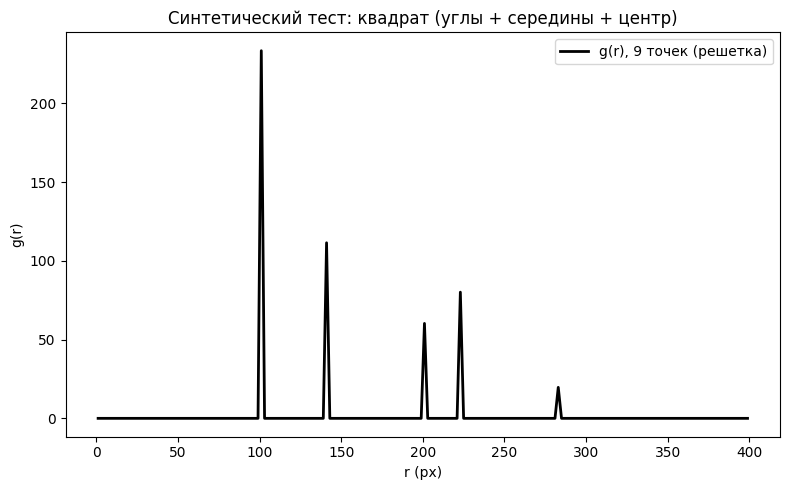

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def accessible_fraction_per_point(xi, yi, r, width, height, n_theta=4000):
    thetas = np.linspace(0, 2*np.pi, n_theta, endpoint=False)
    x_ring = xi + r * np.cos(thetas)
    y_ring = yi + r * np.sin(thetas)
    inside = (x_ring >= 0) & (x_ring < width) & (y_ring >= 0) & (y_ring < height)
    return np.mean(inside)

def rdf_isotropic(x, y, width, height, dr=2.0, r_max=None, n_theta=4000):
    x = np.asarray(x, float); y = np.asarray(y, float)
    n = len(x); assert n >= 2
    if r_max is None: r_max = 0.35 * min(width, height)

    area = width * height
    rho = n / area

    r_edges = np.arange(0, r_max + dr, dr, dtype=float)
    r = 0.5 * (r_edges[:-1] + r_edges[1:])
    g = np.zeros_like(r)

    for i in range(n):
        dx = x - x[i]
        dy = y - y[i]
        d = np.sqrt(dx*dx + dy*dy)
        d = d[d > 0]

        hist, _ = np.histogram(d, bins=r_edges)

        Fi = np.array([accessible_fraction_per_point(x[i], y[i], rk, width, height, n_theta)
                       for rk in r])
        Ai = 2*np.pi*r*dr * Fi

        g += hist / (rho * Ai)

    g /= n
    return r, g


L = 200
margin = 200

x_corners = np.array([0, L, L, 0])
y_corners = np.array([0, 0, L, L])

x_mids = np.array([L/2, L/2, 0, L])
y_mids = np.array([0, L, L/2, L/2])

x_center = np.array([L/2])
y_center = np.array([L/2])

x = np.concatenate([x_corners, x_mids, x_center]) + margin
y = np.concatenate([y_corners, y_mids, y_center]) + margin

W, H = 1000, 1000
r, g = rdf_isotropic(x, y, W, H, dr=2, r_max=400, n_theta=4000)

plt.figure(figsize=(8,5))
plt.plot(r, g, 'k-', lw=2, label="g(r), 9 точек (решетка)")
plt.xlabel("r (px)")
plt.ylabel("g(r)")
plt.title("Синтетический тест: квадрат (углы + середины + центр)")
plt.legend()
plt.tight_layout()
plt.show()
